# Springboard Capstone Project 2
## Hybrid (two-phase) training
___

Another way to gain the benefits of both the downsampled and full image sets is to train the same model on both. In this technique, the model is first trained to convergence on the downsampled image set to establish decent performance on all classes. Then, the model is trained on the full image set to gain the benefits of the large set size for boosting performance on the higher-representation classes. In this implementation of hybrid training, all layers were allowed to update during the second phase. Balanced class weights were used in the second phase to prevent the decay in performance on the lower-representation classes that would occur if the higher-representation classes were mostly driving the gradient descent of the loss function.

A milder weighting scheme was also tested, where the weight of each class in the second training phase was the square root of its weight in the balanced case. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import importlib as imp
import gc

# custom module for capstone 2
import cap2tools as c2t
imp.reload(c2t)

Using TensorFlow backend.


<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
photos_path = 'H:/springboard/other_data/yelp/Photos/final_photos/'
train_path = photos_path + 'train'
valid_path = photos_path + 'val'

# build image generators to feed CNN
train_batches, valid_batches = c2t.build_datagens(train_path, valid_path, augment=True)

Found 230992 images belonging to 5 classes.
Found 20000 images belonging to 5 classes.


In [5]:
# load model
model = load_model('models/downsample_model_1.h5')

In [4]:
# set balanced class weights
images_df = pd.read_csv('photo_labels_all.csv')
train_df = images_df[images_df.set == 'train']
counts = train_df.label.value_counts()
weights = counts.food/counts
weights_df = pd.DataFrame(counts)
weights_df.columns = ['count']
weights_df['weight'] = weights
weights_df['i'] = [1, 2, 4, 0, 3]
weights_df.set_index('i', inplace=True)
weights_dict = weights_df.weight.to_dict()

In [7]:
# define callbacks
filepath = 'models/hybrid_training_model.h5'
saver = ModelCheckpoint(filepath,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True)

stopper = EarlyStopping(monitor='val_loss', 
                        patience=2, 
                        verbose=1)

# train model
n_epochs = 5

history = model.fit_generator(train_batches, 
                              validation_data=valid_batches,
                              epochs=n_epochs,
                              class_weight=weights_dict,
                              verbose=1, 
                              callbacks=[saver, stopper])

# clear clutter from memory
del model
K.clear_session()
gc.collect()

Epoch 1/5
28874/28874 [==============================] - 6502s 225ms/step - loss: 1.2230 - acc: 0.8664 - val_loss: 0.2918 - val_acc: 0.8932

Epoch 00001: val_loss improved from inf to 0.29182, saving model to models/hybrid_training_model.h5
Epoch 2/5
28874/28874 [==============================] - 6489s 225ms/step - loss: 1.1548 - acc: 0.8728 - val_loss: 0.2890 - val_acc: 0.8950

Epoch 00002: val_loss improved from 0.29182 to 0.28900, saving model to models/hybrid_training_model.h5
Epoch 3/5
28874/28874 [==============================] - 6489s 225ms/step - loss: 1.1501 - acc: 0.8736 - val_loss: 0.2725 - val_acc: 0.9005

Epoch 00003: val_loss improved from 0.28900 to 0.27248, saving model to models/hybrid_training_model.h5
Epoch 4/5
28874/28874 [==============================] - 6492s 225ms/step - loss: 1.1202 - acc: 0.8758 - val_loss: 0.2716 - val_acc: 0.9012

Epoch 00004: val_loss improved from 0.27248 to 0.27164, saving model to models/hybrid_training_model.h5
Epoch 5/5
28874/28874 [=

18534

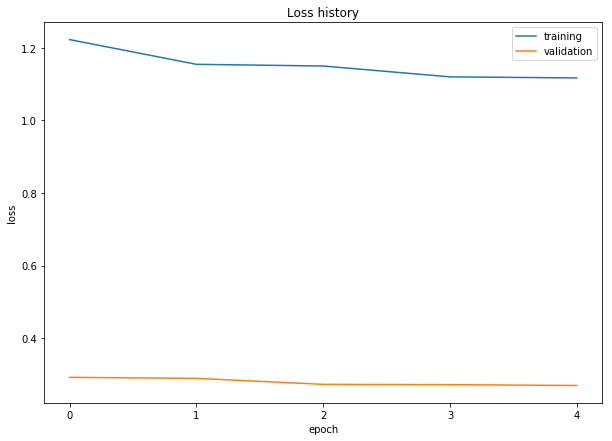

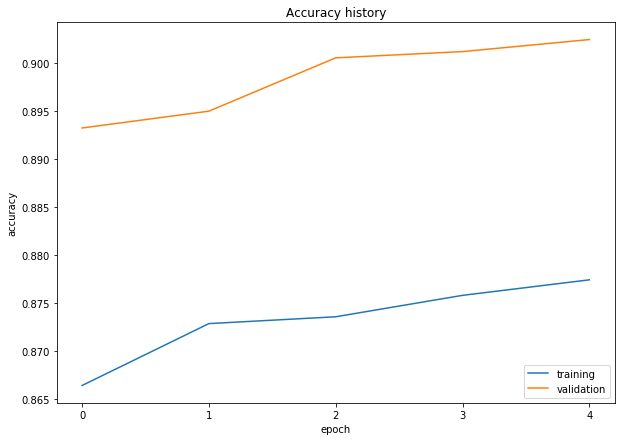

In [8]:
# plot model training history
c2t.plot_history(history)

In [9]:
# evaluate model on validation set
model_paths = {'model': filepath}
model_metrics = c2t.eval_models(model_paths, valid_path)['model']
c2t.print_eval(model_metrics)

Building image generator...
Found 20000 images belonging to 5 classes.
Loading models/hybrid_training_model.h5
Evaluating models/hybrid_training_model.h5
Evaluation complete.

accuracy:  90.24%
loss:  0.2693
pcr:  [0.8828 0.9295 0.8292 0.9905 0.8774]
mean pcr:  90.19%
confusion matrix: 


[[663, 17, 42, 5, 24],
 [538, 12308, 219, 64, 113],
 [80, 64, 3535, 35, 549],
 [0, 0, 0, 104, 1],
 [12, 0, 171, 18, 1438]]

In [5]:
# reload model
model = load_model('models/downsample_model_1.h5')

In [6]:
# try square root of relative abundance for weights
weights_df['sqrt'] = np.sqrt(weights_df.weight)
weights_dict = weights_df.sqrt.to_dict()

In [7]:
# define callbacks
filepath = 'models/hybrid_training_model_sqrt.h5'
saver = ModelCheckpoint(filepath,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True)

stopper = EarlyStopping(monitor='val_loss', 
                        patience=2, 
                        verbose=1)

# train model
n_epochs = 5

history = model.fit_generator(train_batches, 
                              validation_data=valid_batches,
                              epochs=n_epochs,
                              class_weight=weights_dict,
                              verbose=1, 
                              callbacks=[saver, stopper])

# clear clutter from memory
del model
K.clear_session()
gc.collect()

Epoch 1/5
28874/28874 [==============================] - 6534s 226ms/step - loss: 0.5160 - acc: 0.9042 - val_loss: 0.2010 - val_acc: 0.9308

Epoch 00001: val_loss improved from inf to 0.20103, saving model to models/hybrid_training_model_sqrt.h5
Epoch 2/5
28874/28874 [==============================] - 6473s 224ms/step - loss: 0.4878 - acc: 0.9107 - val_loss: 0.1945 - val_acc: 0.9316

Epoch 00002: val_loss improved from 0.20103 to 0.19451, saving model to models/hybrid_training_model_sqrt.h5
Epoch 3/5
28874/28874 [==============================] - 6472s 224ms/step - loss: 0.4763 - acc: 0.9123 - val_loss: 0.1872 - val_acc: 0.9348

Epoch 00003: val_loss improved from 0.19451 to 0.18719, saving model to models/hybrid_training_model_sqrt.h5
Epoch 4/5
28874/28874 [==============================] - 6472s 224ms/step - loss: 0.4666 - acc: 0.9147 - val_loss: 0.1859 - val_acc: 0.9354

Epoch 00004: val_loss improved from 0.18719 to 0.18587, saving model to models/hybrid_training_model_sqrt.h5
Epoc

18105

In [8]:
# evaluate model on validation set
model_paths = {'model': filepath}
model_metrics = c2t.eval_models(model_paths, valid_path)['model']
c2t.print_eval(model_metrics)

Building image generator...
Found 20000 images belonging to 5 classes.
Loading models/hybrid_training_model_sqrt.h5
Evaluating models/hybrid_training_model_sqrt.h5
Evaluation complete.

accuracy:  93.61%
loss:  0.183
pcr:  [0.8123 0.9698 0.8813 0.981  0.8603]
mean pcr:  90.09%
confusion matrix: 


[[610, 50, 63, 4, 24],
 [172, 12842, 161, 15, 52],
 [42, 97, 3757, 16, 351],
 [0, 0, 1, 103, 1],
 [4, 6, 212, 7, 1410]]

In [9]:
# evaluate hybrid-root on the test set
test_path = 'H:/springboard/other_data/yelp/Photos/final_photos/test'
model_metrics = c2t.eval_models(model_paths, test_path)['model']
c2t.print_eval(model_metrics)

Building image generator...
Found 30000 images belonging to 5 classes.
Loading models/hybrid_training_model_sqrt.h5
Evaluating models/hybrid_training_model_sqrt.h5
Evaluation complete.

accuracy:  93.43%
loss:  0.1851
pcr:  [0.8131 0.9712 0.8782 0.9669 0.8445]
mean pcr:  89.48%
confusion matrix: 


[[905, 106, 72, 2, 28],
 [243, 19061, 226, 27, 69],
 [72, 125, 5860, 21, 595],
 [0, 2, 0, 146, 3],
 [6, 13, 346, 14, 2058]]